# Classification supervisée

In [79]:
import pandas as pd
import numpy as np
import scipy.stats as sps

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Scikit learn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier 

#Lecture des données 
import pickle

In [80]:
#path_test = "../../4A/Projet/Ensemble de test/"
path_test = "../Donnees_projet/Ensemble_de_test/"

In [81]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_propre, ind_recupere = mon_depickler.load()

In [82]:
n = len(liste_propre)
liste_appr = list(np.asarray(liste_propre)[np.asarray(ind_recupere) <= 299])
liste_test = list(np.asarray(liste_propre)[np.asarray(ind_recupere) > 299])
n_appr = len(liste_appr)
n_test = len(liste_test)

In [83]:
anom = [False] * n_test
type_anom = [-1] * n_test
loc = [-1] * n_test

anom[73] = True
type_anom[73] = 1
loc[73] = 200

anom[96] = True
type_anom[96] = 1
loc[96] = 300

anom[36] = True
type_anom[36] = 1
loc[36] = 400

anom[32] = True
type_anom[32] = 1
loc[32] = 300

anom[33] = True
type_anom[33] = 1
loc[33] = 200

anom[107] = True
type_anom[107] = 2
loc[107] = 600

anom[60] = True
type_anom[60] = 2
loc[60] = 400

anom[113] = True
type_anom[113] = 2
loc[113] = 400

anom[9] = True
type_anom[9] = 2
loc[9] = 200

anom[11] = True
type_anom[11] = 2
loc[11] = 300

anom[53] = True
type_anom[53] = 3
loc[53] = 400

anom[114] = True
type_anom[114] = 3
loc[114] = 400

anom[14] = True
type_anom[14] = 3
loc[14] = 500

anom[79] = True
type_anom[79] = 3
loc[79] = 400

anom[29] = True
type_anom[29] = 3
loc[29] = 300

anom[27] = True
type_anom[27] = 4
loc[27] = 300

anom[121] = True
type_anom[121] = 4
loc[121] = 300

anom[5] = True
type_anom[5] = 4
loc[5] = 400

anom[89] = True
type_anom[89] = 4
loc[89] = 200

anom[99] = True
type_anom[99] = 4
loc[99] = 100  

anom = [False] * n_appr + anom
type_anom = [-1] * n_appr + type_anom
loc = [-1] * n_appr + loc

In [84]:
ind_anom = list(np.where(np.asarray(anom))[0]) # Indices des anomalies

In [85]:
def df_fenetres(liste_comp, N, anom, loc):
    serie = []
    #origine = []
    ind_debut = []
    valeurs = []
    anom_fen = []
    for i, val, loc_i in zip(ind_recupere, liste_comp, loc):
        # Liste des fenêtres de l'enregistrement
        fenetres = [val[i * N:(i + 1) * N] for i in range((len(val) + N - 1) // N ) if len(val[i * N:(i + 1) * N]) == N]
        nb_fen = len(fenetres)
        valeurs += fenetres
        anom_fen_i = [False] * nb_fen
        pos_anom_deb_fen = loc_i // N
        pos_anom_fin_fen = (loc_i + 55) // N
        if loc_i > -1:
            try:
                for pos in range(pos_anom_deb_fen, pos_anom_fin_fen + 1):
                    anom_fen_i[pos] = True

            except IndexError:
                pass
                """Cette erreur est levée lorsque l'anomalie se trouve en fin de série, dans une plage qui n'a pas été capturée 
                par une des fenêtres. On peut donc l'ignorer et continuer le traitement. Ce cas est de toute façon très rare
                dans nos données."""
        anom_fen += anom_fen_i
        ind_debut += list(range(0, nb_fen * N, N))
        serie += [i] * nb_fen
        """if i < 300:
            origine += ["appr"] * nb_fen
        else:
            origine += ["test"] * nb_fen"""
        
    
    df = pd.DataFrame(data={"id" : list(range(len(serie))), "serie" : serie, "ind_debut" : ind_debut, "valeurs" : valeurs, "anom" : anom_fen})
        
    return df.set_index(["id"])

In [86]:
N = 80
data_fenetres = df_fenetres(liste_propre, N, anom, loc)

In [87]:
ind_anom = list(data_fenetres[data_fenetres["anom"]]["serie"].values)

In [135]:
# Toutes les fenetres des séries contenant une anomalie
data_ajout_anom = data_fenetres.loc[data_fenetres["serie"].isin(ind_anom)] 
# On met un indice d'une grande puisance de 10 pour identifier plus facilement les fenetres ajoutees
offset = 10 ** (int(np.log10(data_fenetres.index.values[-1])) + 1)

df_supervise = data_fenetres
for i in range(1,3):
    data_ajout_anom.index += offset
    data_ajout_anom.serie += offset
    df_supervise = pd.concat([df_supervise, data_ajout_anom])
    
# df_supervise contient les données d'apprentissage + les données de tests + les séries anormales recopiées 4 fois
# les séries recopiées ont pour indice leur indice de départ + k*offset pour k=1,..,4
df_supervise.tail(50)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,serie,ind_debut,valeurs,anom,min,max,mean,std,skew,kurt,energy,average_cross
id,,,,,,,,,,,,
23120,20379,480,"[1736.0, 1744.0, 1744.0, 1744.0, 1736.0, 1736....",False,-1.487393,-0.398950,-1.113270,0.069942,0.421983,-0.329100,-0.931143,-1.019770
23183,20389,0,"[1408.0, 1408.0, 1416.0, 1416.0, 1408.0, 1392....",False,-1.120799,-0.125033,-1.080946,0.188032,0.717682,-0.095262,-0.900319,-1.281262
23184,20389,80,"[1776.0, 1768.0, 1760.0, 1752.0, 1744.0, 1736....",False,0.764542,0.253233,0.432342,-0.234208,1.838372,1.650946,0.262166,-1.019770
23185,20389,160,"[1712.0, 1720.0, 1728.0, 1736.0, 1736.0, 1736....",True,-2.416970,-0.398950,-0.957038,0.681360,-0.508641,-0.680021,-0.766028,0.483808
23186,20389,240,"[1258.0, 1258.0, 1266.0, 1282.0, 1274.0, 1266....",True,-1.998006,2.548920,1.913711,2.976023,-0.063708,-0.504578,2.166144,-0.366040
23187,20389,320,"[2704.0, 2696.0, 2696.0, 2696.0, 2464.0, 2048....",False,0.607430,1.153247,0.557866,0.636229,1.641474,1.076765,0.432229,-1.738873
23188,20389,400,"[1728.0, 1720.0, 1720.0, 1720.0, 1720.0, 1712....",False,-1.592134,-0.411994,-0.654273,0.266551,-0.477614,-0.667638,-0.581345,0.353062
23251,20396,0,"[1400.0, 1400.0, 1408.0, 1408.0, 1424.0, 1424....",False,-1.120799,-0.933741,-1.426810,-0.605041,-0.471577,-0.477658,-1.171955,0.810673
23252,20396,80,"[1400.0, 1392.0, 1392.0, 1400.0, 1400.0, 1400....",False,-1.068428,-0.151120,0.186143,-0.046701,-1.701466,0.046633,0.063436,2.444997


In [136]:
def plot_anom_type(Type):
    for num in df_supervise.index.values:
        TS = df_supervise.loc[num]
        loc = TS["loc"]
        serie = TS["valeurs"]

        if TS["type"] == Type: 
            fig, ax = plt.subplots(figsize=(12, 7))
            plt.title("Série numéro " + str(num) + ", type " + str(Type), size=20, color='r', fontweight='bold')

            ax.plot(range(loc), serie[: loc], 'b')
            ax.plot(range(loc - 1, loc + 56), serie[loc - 1 : loc + 56], 'r')
            ax.plot(range(loc + 55, len(serie)), serie[loc + 55 :], 'b')

        plt.show()

In [137]:
try:
    for T in range(1, 5):
        plot_anom_type(T)
except KeyError:
    print("Marche plus avec le nouveau DataFrame, à adapter si besoin.")

Marche plus avec le nouveau DataFrame, à adapter si besoin.


## Méthodes de Classification

## Random Forest

### Calcul des features

In [91]:
df_supervise["min"] = list(map(min, df_supervise.valeurs))
df_supervise["max"] = list(map(max, df_supervise.valeurs))
df_supervise["mean"] = list(map(np.mean, df_supervise.valeurs))
df_supervise["std"] = list(map(np.std, df_supervise.valeurs))
df_supervise["skew"] = list(map(sps.skew, df_supervise.valeurs))
df_supervise["kurt"] = list(map(sps.kurtosis, df_supervise.valeurs))
df_supervise["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), df_supervise.valeurs))
df_supervise["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), df_supervise.valeurs))

In [92]:
scaler = preprocessing.StandardScaler()
names_features = ["min", "max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    df_supervise[col] = scaler.fit_transform(df_supervise[col].values.reshape(-1, 1))

In [93]:
taille_test = df_supervise.shape[0] // 3
X_train, X_test, Y_train, Y_test = train_test_split(df_supervise[names_features], df_supervise["anom"], test_size=taille_test)

In [94]:
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2,
                                min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train, Y_train)
print(1 - rfFit.oob_score_)

0.002039151712887488


In [95]:
# erreur de prévision sur le test
1 - rfFit.score(X_test, Y_test)

0.004081632653061273

In [96]:
param = [{"max_features" : list(range(2, len(names_features) + 1))}]
rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.004078, Meilleur paramètre = {'max_features': 2}


In [97]:
# erreur de prévision sur le test
1 - rfOpt.score(X_test,Y_test)

0.004081632653061273

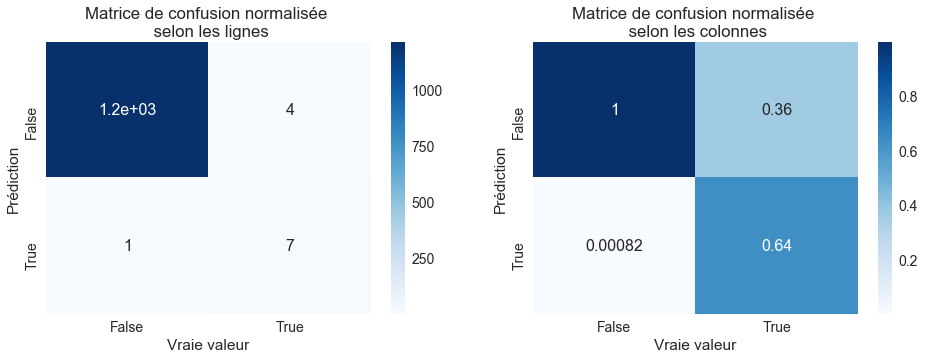

In [98]:
# prévision
y_chap = rfOpt.predict(X_test)
# matrice de confusion
# Options pour normalize : all, index, column
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize=False) # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
sns.set(font_scale=1.4)#for label size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[0], annot_kws={"size": 16}) # font size
ax[0].set_title("Matrice de confusion normalisée \n selon les lignes")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1], annot_kws={"size": 16}) # font size
ax[1].set_title("Matrice de confusion normalisée \n selon les colonnes")
plt.show()

Commentaire : 1,2% d'erreurs, c'est très faible mais si on regarde la matrice de confusion on voit que la prévision n'est en fait pas si efficace. En effet on observe beaucoup de faux négatifs, envion un tiers. On a pas contre quasi aucun faux positif.

On teste la même chose mais sans dupliquer les anomalies.

In [99]:
data_fenetres["min"] = list(map(min, data_fenetres.valeurs))
data_fenetres["max"] = list(map(max, data_fenetres.valeurs))
data_fenetres["mean"] = list(map(np.mean, data_fenetres.valeurs))
data_fenetres["std"] = list(map(np.std, data_fenetres.valeurs))
data_fenetres["skew"] = list(map(sps.skew, data_fenetres.valeurs))
data_fenetres["kurt"] = list(map(sps.kurtosis, data_fenetres.valeurs))
data_fenetres["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), data_fenetres.valeurs))
data_fenetres["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), data_fenetres.valeurs))

In [100]:
scaler = preprocessing.StandardScaler()
names_features = ["min", "max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    data_fenetres[col] = scaler.fit_transform(data_fenetres[col].values.reshape(-1, 1))

In [101]:
taille_test = data_fenetres.shape[0] // 3
X_train, X_test, Y_train, Y_test = train_test_split(data_fenetres[names_features], data_fenetres["anom"], test_size=taille_test)

In [102]:
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train, Y_train)
print(1 - rfFit.oob_score_)

0.009783071033602764


In [103]:
# erreur de prévision sur le test
1 - rfFit.score(X_test, Y_test)

0.007659574468085073

In [104]:
param = [{"max_features" : list(range(2, len(names_features) + 1))}]
rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))

Meilleur score = 0.009358, Meilleur paramètre = {'max_features': 2}


In [105]:
# erreur de prévision sur le test
1 - rfOpt.score(X_test, Y_test)

0.007659574468085073

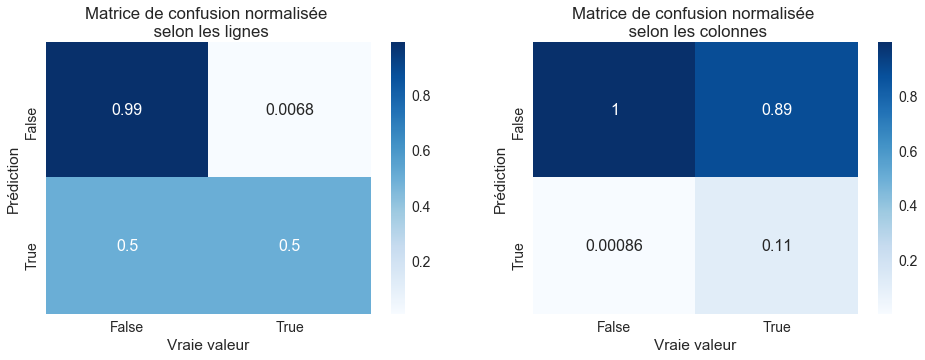

In [106]:
# prévision
y_chap = rfFit.predict(X_test)
# matrice de confusion
# Options pour normalize : all, index, column
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
sns.set(font_scale=1.4)#for label size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[0], annot_kws={"size": 16}) # font size
ax[0].set_title("Matrice de confusion normalisée \n selon les lignes")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1], annot_kws={"size": 16}) # font size
ax[1].set_title("Matrice de confusion normalisée \n selon les colonnes")
plt.show()

Commentaire : Le modèle répond quasi systématiquement Non, et donc se trompe très peu. C'est parfaitement inexploitable, il faut garder la version en dupliquant les anomalies ou trouver une autre idée.

### Coefficients de Fourier

In [153]:
from scipy.fftpack import fft
fftCoeff =[]
for x in df_supervise["valeurs"]:
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre))
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)
    
fftCoeff = np.array(fftCoeff)
print(fftCoeff.shape)

#Coefficients seuillés
prop_a_garder = 0.1
nb_coeffs = int(fftCoeff.shape[1] * prop_a_garder)
somme = np.sum(fftCoeff**2, axis=0)
fftCoeff_seuil = np.zeros((0, nb_coeffs))
ind_grands = np.argsort(somme)[-nb_coeffs :]
fftCoeff_seuil = fftCoeff[:, ind_grands]

print(fftCoeff_seuil.shape)

(3828, 80)
(3828, 8)


In [154]:
df_Fourier = pd.DataFrame(fftCoeff)
df_Fourier_seuil = pd.DataFrame(fftCoeff_seuil)

In [155]:
for col in df_Fourier.columns :
    df_Fourier[col] = scaler.fit_transform(df_Fourier[col].values.reshape(-1, 1))
for col in df_Fourier_seuil.columns :
    df_Fourier_seuil[col] = scaler.fit_transform(df_Fourier_seuil[col].values.reshape(-1, 1))

### Coefficients d'ondelettes

In [156]:
import pywt
from pywt import wavedec
from statsmodels.robust import mad

wavelist=['haar', 'db2']

wavelist=['haar', 'db2'] 

Coeff_ond_haar = []
Coeff_ond_db2 = []

for x in df_supervise["valeurs"]:
    #Apply wavelet decomposition
    coeffs_haar = pywt.wavedec(x, wavelist[0], level=4) 
    coeffs_flatten_haar, coeff_slices_haar = pywt.coeffs_to_array(coeffs_haar)
    Coeff_ond_haar.append(coeffs_flatten_haar)
    #Apply wavelet decomposition
    coeffs_db2 = pywt.wavedec(x, wavelist[1], level=4) 
    coeffs_flatten_db2, coeff_slices_db2 = pywt.coeffs_to_array(coeffs_db2)
    Coeff_ond_db2.append(coeffs_flatten_db2)
    
    
Coeff_ond_haar = np.array(Coeff_ond_haar)
Coeff_ond_db2 = np.array(Coeff_ond_db2)

print(Coeff_ond_haar.shape, Coeff_ond_db2.shape)

/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[a_slices] = a_coeffs
/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[slice_array] = d


(3828, 80) (3828, 89)


In [157]:
df_ond_haar = pd.DataFrame(Coeff_ond_haar)
df_ond_db2 = pd.DataFrame(Coeff_ond_db2)

In [158]:
#for col in df_ond_haar.columns :
#    df_ond_haar[col] = scaler.fit_transform(df_ond_haar[col].values.reshape(-1, 1))
#for col in df_ond_db2.columns :
#    df_ond_db2[col] = scaler.fit_transform(df_ond_db2[col].values.reshape(-1, 1))

### Visualisation des résultats

In [159]:
# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

df_liste = ["Features",
            "Ondelettes_haar",
            "Ondelettes_db2",
            "Coefficients de Fourier",
            "Coefficients de Fourier seuillés"
           ]

dict_df = {"Features" : df_supervise[names_features],
           "Ondelettes_haar" : df_ond_haar,
           "Ondelettes_db2" : df_ond_db2,
           "Coefficients de Fourier" : df_Fourier,
           "Coefficients de Fourier seuillés" : df_Fourier_seuil
          }

taille_max = df_supervise.shape[0]
print(taille_max)

3828


In [114]:
df_supervise

,serie,ind_debut,valeurs,anom,min,max,mean,std,skew,kurt,energy,average_cross
id,,,,,,,,,,,,
0,0,0,"[1424.0, 1432.0, 1432.0, 1416.0, 1408.0, 1408....",False,-1.056980,-0.376448,-0.758268,0.091665,-0.286768,-0.646155,-0.671629,0.157163
1,0,80,"[1696.0, 1704.0, 1704.0, 1712.0, 1704.0, 1696....",False,0.822152,1.834764,0.952677,1.376824,0.948327,0.186632,0.883705,-1.081680
2,0,160,"[1696.0, 1664.0, 1632.0, 1624.0, 1616.0, 1624....",False,0.404567,1.184408,1.988037,0.749499,-0.619216,-0.458545,1.771899,1.069994
3,0,240,"[2056.0, 2056.0, 2056.0, 2048.0, 2008.0, 1808....",False,0.300171,0.091809,0.073344,-0.130454,1.537005,0.943609,-0.033962,-1.733702
4,0,320,"[1664.0, 1664.0, 1664.0, 1664.0, 1656.0, 1656....",False,0.561162,-0.506519,-0.040325,-0.611756,-0.481652,-0.371563,-0.138247,1.396005
5,0,400,"[1680.0, 1680.0, 1672.0, 1664.0, 1672.0, 1672....",False,0.404567,1.652664,0.530704,0.839018,1.295078,0.794058,0.432740,-1.081680
6,0,480,"[1656.0, 1672.0, 1672.0, 1672.0, 1672.0, 1664....",False,0.456765,-0.207355,0.032059,-0.472525,2.179342,2.587833,-0.078067,-0.234051
7,0,560,"[1664.0, 1672.0, 1664.0, 1664.0, 1672.0, 1672....",False,-1.787754,2.524142,0.944634,3.161612,0.473200,-0.259440,1.315200,-1.016477
8,1,0,"[1400.0, 1384.0, 1384.0, 1392.0, 1400.0, 1400....",False,-1.213574,-0.207355,-1.325008,-0.056717,1.393214,0.728676,-1.086911,-1.603297


In [115]:
@interact(Choix_df=df_liste, taille_test=widgets.IntSlider(min=100, max=taille_max - 100, step=100, 
                                                           value=taille_max//3, continuous_update=False), 
          button=widgets.ToggleButton(description="Refresh"))

def RandomForest(Choix_df, taille_test, button):
    df_coeff = dict_df[Choix_df]
    #print("Proportion de fenêtres utilisées pour l'apprentissage : ", 1 - taille_test / df_coeff.shape[0])
    X_train, X_test, Y_train, Y_test = train_test_split(df_coeff, df_supervise["anom"], test_size=taille_test)
    
    # définition des paramètres
    
    # apprentissage
    
    max_feat = 5
    param = [{"max_features" : list(range(2, min(max_feat, df_coeff.shape[1]) + 1))}]
    rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)

    rfOpt = rf.fit(X_train, Y_train)
    
    #print("Erreur Out of bag : ", 1 - rfOpt.oob_score_)  # N'existe pas sur les objets GridSearchCV, hélas
    # erreur de prévision sur le test
    #print("Erreur de prévision sur le test : ", 1 - rfOpt.score(X_test, Y_test))
    # paramètre optimal
    #print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))
    
    forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2,
                                    min_samples_leaf=1, max_features=rfOpt.best_params_['max_features'], 
                                    max_leaf_nodes=None, bootstrap=True, oob_score=True)
    rfFit = forest.fit(X_train, Y_train)
    
    # prévision
    y_chap = rfOpt.predict(X_test)
    
    
    df_supervise["pred"] = np.array([False] * df_supervise.shape[0])
    for ind, ind_fen in enumerate(Y_test.index):
        df_supervise.loc[ind_fen, "pred"] = y_chap[ind]
        
    ind_series_anom = np.unique(df_supervise[df_supervise["pred"]]["serie"].values)
    print("Séries contenant une anomalie : ", ind_series_anom)
    # matrice de confusion

    table = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize=False)
    table_norm = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="all")
    table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index")
    table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
    sns.set(font_scale=1.4)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    sns.heatmap(table, annot=True, cmap="Blues", ax=ax[0, 0], annot_kws={"size": 16})
    ax[0, 0].set_title("Matrice de confusion brute")
    sns.heatmap(table_norm, annot=True, cmap="Blues", ax=ax[0, 1], annot_kws={"size": 16})
    ax[0, 1].set_title("Matrice de confusion normalisée")
    sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[1, 0], annot_kws={"size": 16})
    ax[1, 0].set_title("Matrice de confusion normalisée selon les lignes")
    sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1, 1], annot_kws={"size": 16})
    ax[1, 1].set_title("Matrice de confusion normalisée selon les colonnes")
    plt.show()

    for num in ind_series_anom:

        fig, ax = plt.subplots(figsize=(8, 5))
        TS = df_supervise[(df_supervise["serie"] == num)]["valeurs"].values
        anoms = df_supervise[df_supervise["serie"] == num]["pred"].values
        title_obj = plt.title("Série numéro " + str(num % offset), size=25)
        for (i, x), anom in zip(enumerate(TS), anoms):

            if i > 0:  # Raccordement
                ax.plot([N * i - 1, N * i], [last, x[0]], "br"[int(anom)])

            ax.plot(range(N * i, N * (i + 1)),  x, "br"[int(anom)])
            last = x[-1]
            if anom:
                plt.setp(title_obj, color='r', fontweight="bold")
    
        plt.show()

interactive(children=(Dropdown(description='Choix_df', options=('Features', 'Ondelettes_haar', 'Ondelettes_db2…

**Commentaires :**

Très peu d'erreur avec les coefficients d'ondelettes (haar ou db2) et même parfois 0 erreur.

Avec les coefficients de Fourier : résulats quasi identiques à ceux de Features, parfois meilleurs, parfois pires.

### A FINIR

In [116]:
# RandomForest sur coefficients d'ondelettes db2

X_train, X_test, Y_train, Y_test = train_test_split(Coeff_ond_db2, df_supervise["anom"],
                                                    test_size=Coeff_ond_db2.shape[1] // 3)

max_feat = 16
param = [{"max_features" : list(range(2, min(max_feat, Coeff_ond_db2.shape[1]) + 1))}]
rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train)

# erreur de prévision sur le test
print("Erreur de prévision sur le test : ", 1 - rfOpt.score(X_test, Y_test))
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))

# forest optimal
forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2,
                                min_samples_leaf=1, max_features=2, max_leaf_nodes=None, bootstrap=True,
                                oob_score=True)
rfFit = forest.fit(X_train, Y_train)

Erreur de prévision sur le test :  0.0
Meilleur score = 0.001371, Meilleur paramètre = {'max_features': 8}


In [117]:
print("Importance de chaque coefficient : ", rfFit.feature_importances_)

Importance de chaque coefficient :  [0.01773671 0.01589629 0.01627463 0.01913002 0.01519966 0.01447926
 0.02124101 0.00847457 0.00887331 0.01077052 0.00987878 0.00950757
 0.00841049 0.00852962 0.01082398 0.00857131 0.01171887 0.01144793
 0.0093747  0.01296968 0.01080099 0.01064155 0.01152595 0.00966916
 0.01023527 0.00883912 0.0113144  0.01203262 0.01104489 0.01332855
 0.01238094 0.01037894 0.01030339 0.01173294 0.01043926 0.01082439
 0.01484505 0.00993075 0.0115441  0.00969662 0.00952565 0.01165339
 0.0094545  0.00941301 0.00940423 0.00951638 0.00736443 0.01035376
 0.00751547 0.01116863 0.00913996 0.01107399 0.011388   0.01073139
 0.01154048 0.01630849 0.01659082 0.01047318 0.01330304 0.01133903
 0.01163729 0.01064371 0.01073171 0.00722901 0.00838062 0.01166474
 0.01623599 0.00948257 0.01424783 0.01061224 0.00995528 0.01019214
 0.0114806  0.0091771  0.00962146 0.0162748  0.01289831 0.011188
 0.01617051 0.00764042 0.00766736 0.00890053 0.00995698 0.00768395
 0.00947482 0.01348284 0.013

In [118]:
y_chap = rfOpt.predict(X_test)
y_chap

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [119]:
importance = rfFit.feature_importances_

In [120]:
# coefficients triés par ordre d'importance
np.argsort(rfFit.feature_importances_)[::-1] #dans l'ordre

array([ 6,  3,  0, 56, 55, 75,  2, 66, 78,  1,  4, 36,  5, 68, 85, 29, 58,
       86, 19, 76, 30, 27, 33, 16, 65, 41, 60, 38, 54, 22, 72, 17, 52, 59,
       26, 77, 49, 51, 28, 35, 14, 20,  9, 62, 53, 61, 21, 69, 57, 34, 31,
       47, 32, 24, 71, 82, 70, 37, 10, 87, 39, 23, 74, 40, 45, 11, 67, 84,
       42, 43, 44, 18, 73, 50, 81,  8, 25, 15, 13,  7, 12, 64, 83, 80, 79,
       48, 46, 63, 88])

In [121]:
# on ne garde que les 10 coefficients les plus importants pour reconstruire un signal avec anomalie
seuil = np.sort(importance)[-10]
valeurs = df_ond_db2.loc[6, :].values
valeurs_seuil = np.array([v if imp >= seuil else 0 for imp, v in zip(importance, valeurs)])
valeurs_seuil

array([ 6.65101815e+03,  6.62605163e+03,  6.83186869e+03,  6.67265766e+03,
        0.00000000e+00,  0.00000000e+00,  6.65501598e+03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [122]:
plt.plot(pywt.waverecn(pywt.array_to_coeffs(valeurs_seuil, coeff_slices), 'db2'))

NameError: name 'coeff_slices' is not defined

In [ ]:
#le signal d'origine
plt.plot(np.array(df_supervise.loc[6, "valeurs"]))

Tester regression logistique
Pouvoir visualiser l'anomalie
Tester lissage spline ou supprimer les niveaux de détails les plus fins en ondelettes


## Regression Logistique 

### Calcul des features

In [138]:
df_supervise["min"] = list(map(min, df_supervise.valeurs))
df_supervise["max"] = list(map(max, df_supervise.valeurs))
df_supervise["mean"] = list(map(np.mean, df_supervise.valeurs))
df_supervise["std"] = list(map(np.std, df_supervise.valeurs))
df_supervise["skew"] = list(map(sps.skew, df_supervise.valeurs))
df_supervise["kurt"] = list(map(sps.kurtosis, df_supervise.valeurs))
df_supervise["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), df_supervise.valeurs))
df_supervise["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), df_supervise.valeurs))

In [139]:
scaler = preprocessing.StandardScaler()
names_features = ["min", "max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    data_fenetres[col] = scaler.fit_transform(data_fenetres[col].values.reshape(-1, 1))

In [140]:
taille_test = df_supervise.shape[0] // 3
X_train, X_test, Y_train, Y_test = train_test_split(df_supervise[names_features], df_supervise["anom"], test_size=taille_test)

#### Optimisation Lasso

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Grille de valeurs du paramètre de pénalisaiton
param=[{"C": [0.04, 1, 0.010, 10, 12, 15, 30]}]
logitL = GridSearchCV(LogisticRegression(penalty="l1"), param, cv=5, n_jobs=-1)
logitLasso = logitL.fit(X_train, Y_train)
# Sélection du paramètre optimal
logitLasso.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" % (1.-logitLasso.best_score_,logitLasso.best_params_))

Meilleur score (apprentissage) = 0.024687, Meilleur paramètre = {'C': 0.01}


In [185]:
# définition des estimateurs
logit= LogisticRegression(penalty="l1", C=logitLasso.best_params_["C"] )
logitOpt=logit.fit(X_train, Y_train)
# erreur sur l'échantillon test
1-logitOpt.score(X_test, Y_test)

0.024294670846395028

In [186]:
# Prévision
yChap = logitRidge.predict(X_test)
# matrice de confusion
table=pd.crosstab(yChap,Y_test)
print(table)
# Erreur sur l'échantillon test
print("Erreur de test régression Ridge = %f" % (1-logitRidge.score(X_test, Y_test)))

anom   False  True 
row_0              
False   1246     30
Erreur de test régression Ridge = 0.023511


Le modèle "optimal" obtenu est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision.

La matrice de confusion croise les abomalies prédites avec celles effectivement présentes.

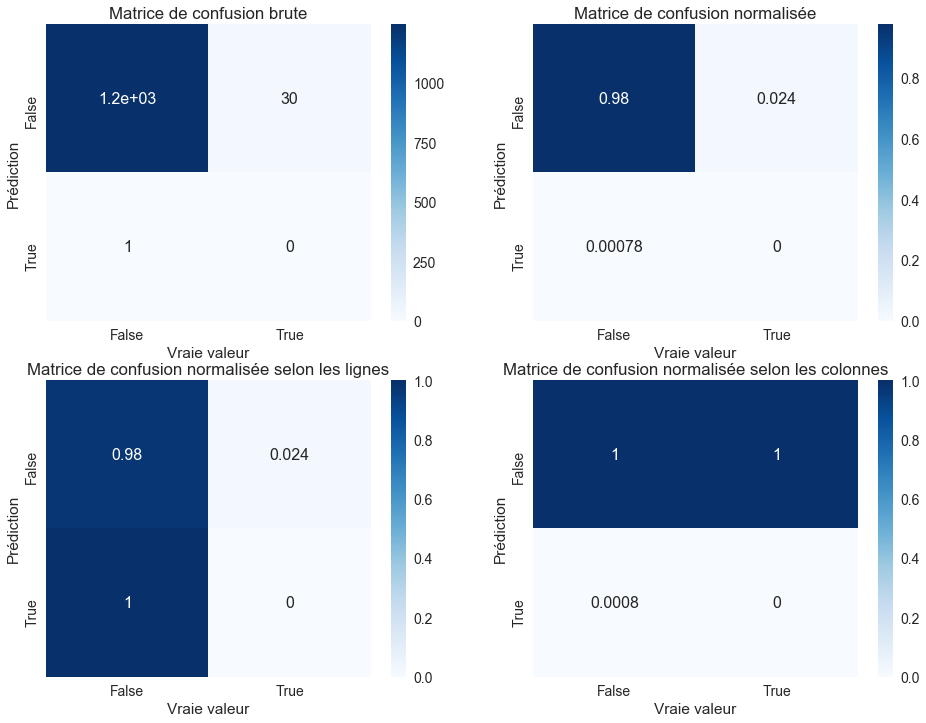

In [143]:
# prévision
y_chap = logitOpt.predict(X_test)
df_supervise["pred"] = np.concatenate((np.array([False] * (df_supervise.shape[0] - len(y_chap))), y_chap))
ind_series_anom = np.unique(df_supervise[df_supervise["pred"]]["serie"].values)
# matrice de confusion
table = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize=False) # margins=True, margins_name="Total")
table_norm = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="all")
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
sns.set(font_scale=1.4)  #for label size
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
sns.heatmap(table, annot=True, cmap="Blues", ax=ax[0, 0], annot_kws={"size": 16})  # font size
ax[0, 0].set_title("Matrice de confusion brute")
sns.heatmap(table_norm, annot=True, cmap="Blues", ax=ax[0, 1], annot_kws={"size": 16}) # font size
ax[0, 1].set_title("Matrice de confusion normalisée")
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[1, 0], annot_kws={"size": 16}) # font size
ax[1, 0].set_title("Matrice de confusion normalisée selon les lignes")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1, 1], annot_kws={"size": 16}) # font size
ax[1, 1].set_title("Matrice de confusion normalisée selon les colonnes")
plt.show()

In [188]:
# Coefficients
LassoOpt=LogisticRegression(penalty="l1",C=logitLasso.best_params_["C"])
LassoOpt=LassoOpt.fit(X_train, Y_train)
# Récupération des coefficients
vect_coef=np.matrix.transpose(LassoOpt.coef_)
vect_coef=vect_coef.ravel()
#Affichage des 25 plus importants
coef=pd.Series(abs(vect_coef),index=X_train.columns).sort_values(ascending=False)
print(coef)

skew             4.399791e-01
average_cross    2.433033e-01
kurt             7.631286e-02
std              2.986098e-03
min              7.159139e-04
mean             1.244857e-04
max              8.869694e-05
energy           2.726964e-07
dtype: float64


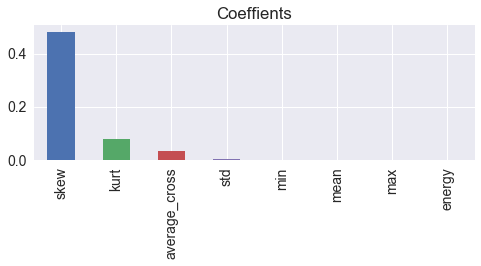

In [145]:
plt.figure(figsize=(7,4))
coef.plot(kind='bar')
plt.title('Coeffients')
plt.tight_layout()
plt.show()

Les coefficients les plus importants dans le cas de features sont ceux de average_cross et skew. 

#### Optimisation ridge

In [195]:
# Grilles de valeurs du paramètre de pénalisation
param=[{"C":[200000, 0.010, 0.01, 0.015, 0.020, 0.030, 0.040]}]
logitR = GridSearchCV(LogisticRegression(penalty="l2"), param, cv=5, n_jobs=-1)
logitRidge = logitR.fit(X_train, Y_train)  
# Sélection du paramètre optimal
logitRidge.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitRidge.best_score_, logitRidge.best_params_))

Meilleur score = 0.024687, Meilleur paramètre = {'C': 200000}


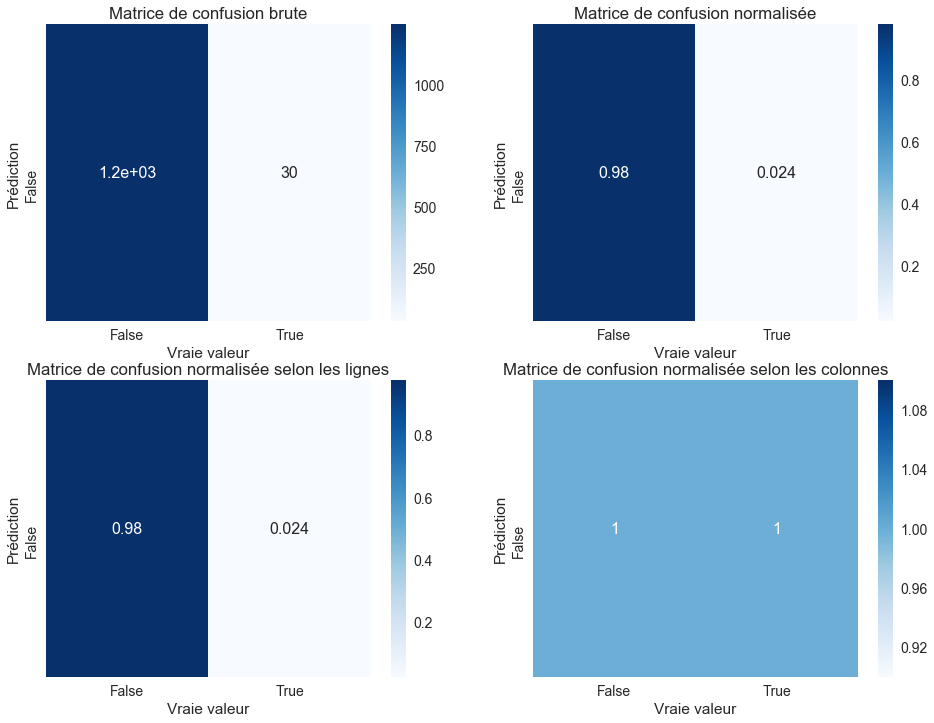

In [149]:
# Prévision
y_chap = logitRidge.predict(X_test)
df_supervise["pred"] = np.concatenate((np.array([False] * (df_supervise.shape[0] - len(y_chap))), y_chap))
ind_series_anom = np.unique(df_supervise[df_supervise["pred"]]["serie"].values)
# matrice de confusion
table = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize=False) # margins=True, margins_name="Total")
table_norm = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="all")
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
sns.set(font_scale=1.4)  #for label size
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
sns.heatmap(table, annot=True, cmap="Blues", ax=ax[0, 0], annot_kws={"size": 16})  # font size
ax[0, 0].set_title("Matrice de confusion brute")
sns.heatmap(table_norm, annot=True, cmap="Blues", ax=ax[0, 1], annot_kws={"size": 16}) # font size
ax[0, 1].set_title("Matrice de confusion normalisée")
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[1, 0], annot_kws={"size": 16}) # font size
ax[1, 0].set_title("Matrice de confusion normalisée selon les lignes")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1, 1], annot_kws={"size": 16}) # font size
ax[1, 1].set_title("Matrice de confusion normalisée selon les colonnes")
plt.show()

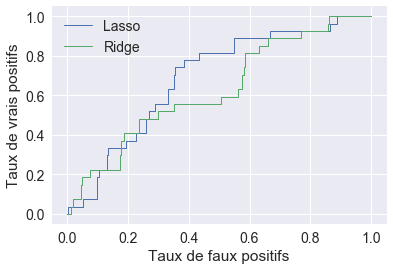

In [133]:
#Courbe ROC, Elle est utile pour comparer Lasso et Ridge 
from sklearn.metrics import roc_curve
listMethod=[["Lasso", logitLasso], ["Ridge", logitRidge]]

for (name, method) in listMethod:
    probas = method.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test, probas[:,1])
    plt.plot(fpr, tpr, lw=1, label=str(name))
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc="best")
plt.show()

### Coefficient de Fourier et d'ondelettes 

#### Visulation par intéract 

#### Optimisation Lasso

In [192]:
@interact(Choix_df=df_liste, taille_test=widgets.IntSlider(min=100, max=taille_max - 100, step=100, 
                                                           value=taille_max//3, continuous_update=False), 
          button=widgets.ToggleButton(description="Refresh"))

def RLLasso(Choix_df, taille_test, button):
    df_coeff = dict_df[Choix_df]
    print("Proportion de fenêtres utilisées pour l'apprentissage : ", 1 - taille_test / df_coeff.shape[0])
    X_train, X_test, Y_train, Y_test = train_test_split(df_coeff, df_supervise["anom"], test_size=taille_test)
    
    param = [{"C": [0.5,0.01,5,10,12,15,30]}]
    logitL = GridSearchCV(LogisticRegression(penalty="l1"), param, cv=5, n_jobs=-1)
    logitLasso = logitL.fit(X_train, Y_train)
    # Sélection du paramètre optimal
    logitLasso.best_params_["C"]
    print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" %
          (1.-logitLasso.best_score_,logitLasso.best_params_))
    
    # définition des estimateurs
    logit= LogisticRegression(penalty="l1", C=logitLasso.best_params_["C"])
    logitOpt = logit.fit(X_train, Y_train)
    # erreur sur l'échantillon test
    print("Erreur sur l'échantillon test : ", 1-logitOpt.score(X_test, Y_test))

    
    # prévision
    y_chap = logitOpt.predict(X_test)
    df_supervise["pred"] = np.array([False] * df_supervise.shape[0])
    for ind, ind_fen in enumerate(Y_test.index):
        df_supervise.loc[ind_fen, "pred"] = y_chap[ind]
        
    ind_series_anom = np.unique(df_supervise[df_supervise["pred"]]["serie"].values)
    print("Séries contenant une anomalie : ", ind_series_anom)
    # matrice de confusion
    table = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize=False) # margins=True, margins_name="Total")
    table_norm = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="all")
    table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
    table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
    sns.set(font_scale=1.4)  #for label size
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    sns.heatmap(table, annot=True, cmap="Blues", ax=ax[0, 0], annot_kws={"size": 16})  # font size
    ax[0, 0].set_title("Confusion matrix")
    sns.heatmap(table_norm, annot=True, cmap="Blues", ax=ax[0,1], annot_kws={"size": 16}) # font size
    ax[0,1].set_title("Confusion matrix normelized")
    sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[1, 0], annot_kws={"size": 16}) # font size
    ax[1, 0].set_title("Confusion matrix normelized by lines")
    sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1,1], annot_kws={"size": 16}) # font size
    ax[1,1].set_title("Confusion matrix normelized by columns")
    plt.show()
    
    for num in ind_series_anom:

        fig, ax = plt.subplots(figsize=(8, 5))
        TS = df_supervise[(df_supervise["serie"] == num)]["valeurs"].values
        anoms = df_supervise[df_supervise["serie"] == num]["pred"].values
        title_obj = plt.title("Série numéro " + str(num % offset), size=25)
        for (i, x), anom in zip(enumerate(TS), anoms):

            if i > 0:  # Raccordement
                ax.plot([N * i - 1, N * i], [last, x[0]], "br"[int(anom)])

            ax.plot(range(N * i, N * (i + 1)),  x, "br"[int(anom)])
            last = x[-1]
            if anom:
                plt.setp(title_obj, color='r', fontweight="bold")
    
        plt.show()

interactive(children=(Dropdown(description='Choix_df', options=('Features', 'Ondelettes_haar', 'Ondelettes_db2…